In [166]:
import importlib
import sys
import time
from copy import deepcopy

import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import torch

import stg_energy.fig4_sensitivity.viz as viz
from pyloric import get_time, simulate, simulate_energyscape, stats
from sbi.utils.regression_net.get_nn_classifier import classifier
from sbi.utils.regression_net.train_classifier import fit_regression_net
from stg_energy.common import col, svg
from stg_energy.fig3_amortize_energy.helper_functions import active_subspace
from stg_energy.fig3_amortize_energy.viz import plot_eigenvalues, py_sensitivity_bars, energy_scape
from stg_energy.fig4_sensitivity.helper_functions import (
    get_gradient,
    prepare_data,
    regression_plot,
)

# Figure 4

In [2]:
%load_ext autoreload
%autoreload 2

In [267]:
PANEL_A = "../svg/panel_a.svg"
PANEL_B1 = "../svg/panel_b1.svg"
PANEL_B2 = "../svg/panel_b2.svg"
PANEL_C1 = "../svg/panel_c1.svg"
PANEL_C2 = "../svg/panel_c2.svg"
PANEL_D1 = "../svg/panel_d1.svg"
PANEL_D2 = "../svg/panel_d2.svg"
PANEL_D3 = "../svg/panel_d3.svg"
PANEL_D4 = "../svg/panel_d4.svg"
PANEL_supp1 = "../svg/panel_supp1.svg"
PANEL_supp2 = "../svg/panel_supp2.svg"

PANEL_A1_NEW = "../svg/panel_a1_new.svg"
PANEL_A2_NEW = "../svg/panel_a2_new.svg"
PANEL_B1_NEW = "../svg/panel_b1_new.svg"
PANEL_B2_NEW = "../svg/panel_b2_new.svg"
PANEL_C_NEW = "../svg/panel_c_new.svg"
PANEL_D1_NEW = "../svg/panel_d1_new.svg"
PANEL_D2_NEW = "../svg/panel_d2_new.svg"
PANEL_D3_NEW = "../svg/panel_d3_new.svg"
PANEL_D4_NEW = "../svg/panel_d4_new.svg"
PANEL_D5_NEW = "../svg/panel_d5_new.svg"
PANEL_D6_NEW = "../svg/panel_d6_new.svg"

### Sort out the data from the cluster

In [4]:
outfile = "../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz"
data_n = np.load(outfile)
sample_seeds = data_n["sample_seeds"]
sample_params = data_n["sample_params"]
sample_stats = data_n["sample_stats"]
print("There are", len(sample_seeds), "datapoints in this dataset")

There are 55043 datapoints in this dataset


# Train regression net

### Prepare parameters

In [5]:
num_test = 500

test_params = sample_params[:num_test]
train_params = sample_params[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

### Prepare energy/spike

In [6]:
all_energies_per_spike_ABPD = sample_stats[:, 18]

In [7]:
numSpikesPerBurst = sample_stats[:, -6] / sample_stats[:, -3]

In [8]:
(
    mean_energies_per_spike,
    std_energies_per_spike,
    train_energies_per_spike_norm,
    test_energies_per_spike_norm,
    mean_num_spikes,
    std_num_spikes,
    train_num_spikes_norm,
    test_num_spikes_norm,
) = prepare_data(all_energies_per_spike_ABPD, numSpikesPerBurst, num_test)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


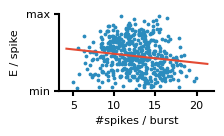

In [9]:
unnorm_x_vals, unnorm_y_regs, unnorm_x, unnorm_y = regression_plot(
    mean_energies_per_spike,
    std_energies_per_spike,
    train_energies_per_spike_norm,
    test_energies_per_spike_norm,
    mean_num_spikes,
    std_num_spikes,
    train_num_spikes_norm,
    test_num_spikes_norm,
)


with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    ax.plot(unnorm_x_vals, unnorm_y_regs, "#e34a33")
    ax.set_xlabel("#spikes / burst")
    ax.set_ylabel("E / spike")
    # -500 and +500 are only for not having half points cut off. I.e. only for visualization.
    ax.set_yticks([np.min(unnorm_y) - 500, np.max(unnorm_y) + 500])
    ax.set_yticklabels(["min", "max"])
    ax.set_ylim([np.min(unnorm_y) - 500, np.max(unnorm_y) + 500])
    # plt.savefig(PANEL_A, facecolor='None', transparent=True)
    plt.show()

### Train classifier

In [10]:
nn = classifier(dim=31)

In [11]:
# converged_nn = fit_regression_net(
#     nn,
#     train_params_norm,
#     train_energies_per_spike_norm,
#     num_train=train_params_norm.shape[0],
#     batch_size=50,
#     stop_after_epochs=10,
#     max_epochs=200
# )

In [12]:
# np.savez('../../results/regression_nets/200821_predict_energyPerSpike_ABPD.npz', converged_nn=converged_nn)

In [13]:
data = np.load(
    "../../results/regression_nets/200821_predict_energyPerSpike_ABPD.npz",
    allow_pickle=True,
)
converged_nn = data["converged_nn"].tolist()

In [14]:
predictions = converged_nn.predict(torch.as_tensor(test_params_norm)).detach().numpy()

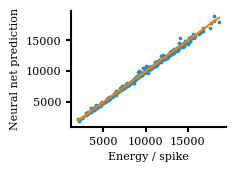

In [15]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
    unnorm_x = (
        test_energies_per_spike_norm[:300] * std_energies_per_spike
        + mean_energies_per_spike
    )
    unnorm_y = predictions[:300] * std_energies_per_spike + mean_energies_per_spike
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Energy / spike")
    ax.set_ylabel("Neural net prediction")
    plt.savefig(PANEL_supp1, facecolor="None", transparent=True)

### Get gradient wrt input

In [16]:
cum_grad = get_gradient(converged_nn, test_params_norm)

### Get active subspace

In [17]:
e_vals_e_per_spike, e_vecs_e_per_spike = active_subspace(converged_nn, test_params_norm)

Ratio of first to second eigenvalue:  tensor(7.5753)


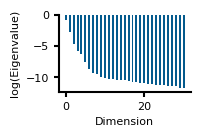

In [18]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    plot_eigenvalues(
        torch.log(torch.flip(e_vals_e_per_spike, dims=(0,))), figsize=(1.7, 1.0)
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals_e_per_spike[-1] / e_vals_e_per_spike[-2],
    )
    plt.show()

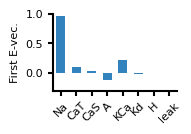

In [227]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    py_sensitivity_bars(
        e_vecs_e_per_spike[0:8, -1:].T,
        ylim=[-0.3, 1.0],
        figsize=(1.6, 1.0),
        ylabel="First E-vec.",
        plot_labels=True,
        color="#3182bd",
    )
    plt.savefig(PANEL_A1_NEW, facecolor="None", transparent=True)
    plt.show()

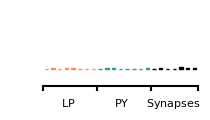

In [228]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.other_sensitivity_bars(
        e_vecs_e_per_spike[8:, -1:].T, ylim=[-0.3, 1.0], figsize=(2.0, 1.0)
    )
    plt.savefig(PANEL_A2_NEW, facecolor="None", transparent=True)
    plt.show()

# Panel B: Sensitivity energy/spike

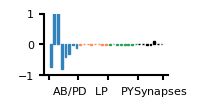

In [229]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.all_sensitivity_bars(cum_grad, ylim=[-1, 1], figsize=(1.6, 0.8))
    plt.savefig(PANEL_B1, facecolor="None", transparent=True)
    plt.show()

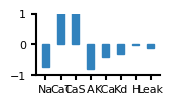

In [230]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.single_neuron_sensitivity_bar(cum_grad, ylim=[-1, 1], figsize=(1.6, 0.8))
    plt.savefig(PANEL_B2, facecolor="None", transparent=True)
    plt.show()

# Panel C: sensitivity number of spikes

In [231]:
nn = classifier(dim=31)

In [232]:
# converged_nn_num_spikes = fit_regression_net(
#     nn,
#     train_params_norm,
#     train_num_spikes_norm,
#     num_train=train_params_norm.shape[0],
#     batch_size=50,
#     stop_after_epochs=10,
#     max_epochs=200
# )

In [233]:
# np.savez('../../results/regression_nets/200821_predict_numSpikes_ABPD.npz', converged_nn=converged_nn_num_spikes)

In [234]:
data = np.load(
    "../../results/regression_nets/200821_predict_numSpikes_ABPD.npz", allow_pickle=True
)
converged_nn_num_spikes = data["converged_nn"].tolist()

In [27]:
predictions = (
    converged_nn_num_spikes.predict(torch.as_tensor(test_params_norm)).detach().numpy()
)

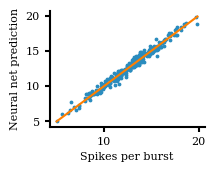

In [28]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
    unnorm_x = test_num_spikes_norm[:300] * std_num_spikes + mean_num_spikes
    unnorm_y = predictions[:300] * std_num_spikes + mean_num_spikes
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Spikes per burst")
    ax.set_ylabel("Neural net prediction")
    plt.savefig(PANEL_supp2, facecolor="None", transparent=True)

### Get gradient wrt output

In [29]:
cum_grad = get_gradient(converged_nn_num_spikes, test_params_norm)

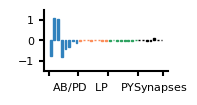

In [30]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.all_sensitivity_bars(cum_grad, ylim=[-1.5, 1.5], figsize=(1.6, 0.8))
    plt.savefig(PANEL_C1, facecolor="None", transparent=True)
    plt.show()

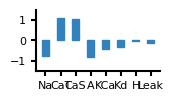

In [31]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.single_neuron_sensitivity_bar(cum_grad, ylim=[-1.5, 1.5], figsize=(1.6, 0.8))
    plt.savefig(PANEL_C2, facecolor="None", transparent=True)
    plt.show()

In [32]:
e_vals_numSpikes, e_vecs_numSpikes = active_subspace(
    converged_nn_num_spikes, test_params_norm
)

Ratio of first to second eigenvalue:  tensor(15.8987)


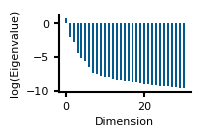

In [33]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    plot_eigenvalues(
        torch.log(torch.flip(e_vals_numSpikes, dims=(0,))), figsize=(1.7, 1.0)
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals_numSpikes[-1] / e_vals_numSpikes[-2],
    )
    plt.show()

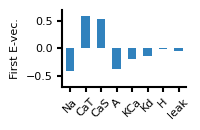

In [235]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    py_sensitivity_bars(
        e_vecs_numSpikes[0:8, -1:].T,
        ylim=[-0.7, 0.7],
        figsize=(1.6, 1.0),
        ylabel="First E-vec.",
        plot_labels=True,
        color="#3182bd",
    )
    plt.savefig(PANEL_B1_NEW, facecolor="None", transparent=True)
    plt.show()

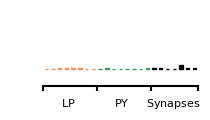

In [236]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.other_sensitivity_bars(
        e_vecs_numSpikes[8:, -1:].T, ylim=[-0.3, 1.0], figsize=(2.0, 1.0)
    )
    plt.savefig(PANEL_B2_NEW, facecolor="None", transparent=True)
    plt.show()

# Project parameters into plane

In [237]:
energies = sample_stats[:, 21:23]
total_energies = np.sum(energies, axis=1)

In [238]:
energies_train = total_energies[500:]

In [239]:
top_1th_train_params_norm = train_params_norm

In [240]:
train_params_norm.shape

(54543, 31)

In [241]:
num_scatter = 10000

projection_mat_e_per_spike_1 = e_vecs_e_per_spike[:, -1:]
projection_mat_e_per_spike_2 = e_vecs_e_per_spike[:, -2:-1]
train_params_norm_tt_top = torch.as_tensor(top_1th_train_params_norm)

projected_e_per_spike_1_top = torch.mm(train_params_norm_tt_top, projection_mat_e_per_spike_1)[
    :num_scatter
]
all_projected_e_per_spike_1_top = torch.mm(
    train_params_norm_tt_top, projection_mat_e_per_spike_1
)

projected_e_per_spike_2_top = torch.mm(train_params_norm_tt_top, projection_mat_e_per_spike_2)[
    :num_scatter
]
all_projected_e_per_spike_2_top = torch.mm(
    train_params_norm_tt_top, projection_mat_e_per_spike_2
)


In [242]:
index_of_minimal_e_per_spike = torch.argmin(all_projected_e_per_spike_1_top[:, 0])
index_of_maximal_e_per_spike = torch.argmax(all_projected_e_per_spike_1_top[:, 0])

minimal_dim0_set_e_per_spike_1 = all_projected_e_per_spike_1_top[
    index_of_minimal_e_per_spike
]
maximal_dim0_set_e_per_spike_1 = all_projected_e_per_spike_1_top[
    index_of_maximal_e_per_spike
]

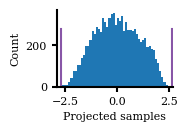

In [243]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    _ = ax.hist(all_projected_e_per_spike_1_top[:10000].T, bins=50)
    ax.axvline(minimal_dim0_set_e_per_spike_1, c="#8856a7", ymin=0, ymax=0.75)
    ax.axvline(maximal_dim0_set_e_per_spike_1, c="#8856a7", ymin=0, ymax=0.75)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Projected samples")
    ax.set_ylabel("Count")

In [244]:
minimal_dim0_set_e_per_spike_2 = projected_e_per_spike_2_top[
    torch.argmin(projected_e_per_spike_2_top[:, 0])
]
maximal_dim0_set_e_per_spike_2 = projected_e_per_spike_2_top[
    torch.argmax(projected_e_per_spike_2_top[:, 0])
]

In [245]:
# with mpl.rc_context(fname="../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
#     _ = ax.hist(all_projected_e_per_spike_2[:10000].T, bins=50)
#     ax.axvline(minimal_dim0_set_e_per_spike_2, c="#8856a7", ymin=0, ymax=0.75)
#     ax.axvline(maximal_dim0_set_e_per_spike_2, c="#8856a7", ymin=0, ymax=0.75)
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
#     ax.set_xlabel("Projected samples")
#     ax.set_ylabel("Count")

In [246]:
projection_mat_numSpikes = e_vecs_numSpikes[:, -1:]

train_params_norm_tt_top = torch.as_tensor(top_1th_train_params_norm)
train_params_norm_tt_bad = torch.as_tensor(bad_99th_train_params_norm)

projected_numSpikes_top = torch.mm(train_params_norm_tt_top, projection_mat_numSpikes)[:num_scatter]
all_projected_numSpikes_top = torch.mm(train_params_norm_tt_top, projection_mat_numSpikes)

projected_numSpikes_bad = torch.mm(train_params_norm_tt_bad, projection_mat_numSpikes)[:num_scatter]
all_projected_numSpikes_bad = torch.mm(train_params_norm_tt_bad, projection_mat_numSpikes)

In [247]:
index_of_minimal_numSpikes = torch.argmin(projected_numSpikes_top[:, 0])
index_of_maximal_numSpikes = torch.argmax(projected_numSpikes_top[:, 0])

minimal_dim0_set_numSpikes = projected_numSpikes_top[
    index_of_minimal_numSpikes
]
maximal_dim0_set_numSpikes = projected_numSpikes_top[
    index_of_maximal_numSpikes
]

In [248]:
# with mpl.rc_context(fname="../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
#     _ = ax.hist(all_projected_numSpikes[:10000].T, bins=50)
#     ax.axvline(minimal_dim0_set_numSpikes, c="#8856a7", ymin=0, ymax=0.75)
#     ax.axvline(maximal_dim0_set_numSpikes, c="#8856a7", ymin=0, ymax=0.75)
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
#     ax.set_xlabel("Projected samples")
#     ax.set_ylabel("Count")

In [249]:
all_projected_numSpikes_top.shape

torch.Size([54543, 1])

In [250]:
energies_train

array([ 789218.87145938, 1693623.31661768, 1710416.51935374, ...,
       1393211.31839852, 1969355.97137056, 1239380.03766832])

In [251]:
parameter_set1 = train_params_norm_tt_top[index_of_minimal_e_per_spike].unsqueeze(0)
parameter_set1_dim1 = torch.mm(parameter_set1, projection_mat_e_per_spike_1)
parameter_set1_dim2 = torch.mm(parameter_set1, projection_mat_numSpikes)

parameter_set2 = train_params_norm_tt_top[index_of_minimal_numSpikes].unsqueeze(0)
parameter_set2_dim1 = torch.mm(parameter_set2, projection_mat_e_per_spike_1)
parameter_set2_dim2 = torch.mm(parameter_set2, projection_mat_numSpikes)

parameter_set3 = train_params_norm_tt_top[index_of_maximal_numSpikes].unsqueeze(0)
parameter_set3_dim1 = torch.mm(parameter_set3, projection_mat_e_per_spike_1)
parameter_set3_dim2 = torch.mm(parameter_set3, projection_mat_numSpikes)

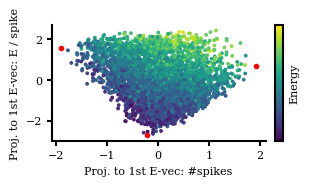

In [292]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))
    im = ax.scatter(
        all_projected_numSpikes_bad[:4000].T, all_projected_e_per_spike_1_top[:4000].T, s=3, c=energies_train[:4000]
    )
    ax.scatter(parameter_set1_dim2, parameter_set1_dim1, color='r')
    ax.scatter(parameter_set2_dim2, parameter_set2_dim1, color='r')
    ax.scatter(parameter_set3_dim2, parameter_set3_dim1, color='r')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Proj. to 1st E-vec: #spikes")
    ax.set_ylabel("Proj. to 1st E-vec: E / spike")
    cbar = plt.colorbar(im, aspect=15,fraction=0.04, pad=0.04)
    cbar.set_ticks([])
    cbar.set_label('Energy', labelpad=5)
    plt.savefig(PANEL_C_NEW, facecolor="None", transparent=True)

In [269]:
parameter_set1.unsqueeze(0)

tensor([[[-1.9874, -1.1522, -0.3110,  1.2203, -2.3909,  1.0611,  1.6872,
           0.5918, -1.8727, -0.7937,  0.7812, -0.1842,  1.1332,  1.5553,
          -0.0666, -1.0856,  0.7224,  0.5368,  0.1368,  0.8334, -1.3468,
           0.9004, -0.3918, -1.4913,  0.1623, -1.5249,  1.4294, -3.0143,
          -0.2380, -1.0470, -0.7097]]])

In [270]:
all_energies_per_spike = sample_stats[:, 18]
all_energies = sample_stats[:, 21]
all_num_spikes = sample_stats[:, 24]

min_energy_per_spike = np.min(all_energies_per_spike)
max_energy_per_spike = np.max(all_energies_per_spike)

min_energy = np.min(all_energies)
max_energy = np.max(all_energies)

min_num_spikes = np.min(all_num_spikes)
max_num_spikes = np.max(all_num_spikes)

In [271]:
sample_stats[0][24]

110.0

In [272]:
unnorm_set_dim_1 = (
    parameter_set1[0] * std_params + mean_params
)
simulation_output_dim0_min = simulate_energyscape(unnorm_set_dim0_min, seed=0)

unnorm_set_dim_2 = (
    parameter_set2[0] * std_params + mean_params
)
simulation_output_dim0_min = simulate_energyscape(unnorm_set_dim0_min, seed=0)

unnorm_set_dim_3 = (
    parameter_set3[0] * std_params + mean_params
)

simulation_output_1 = simulate_energyscape(unnorm_set_dim_1, seed=0)
simulation_output_2 = simulate_energyscape(unnorm_set_dim_2, seed=0)
simulation_output_3 = simulate_energyscape(unnorm_set_dim_3, seed=0)

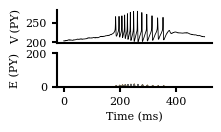

In [273]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    energy_scape(
        simulation_output_1,
        get_time(),
        (2.0, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=116000,
        neuron=0
    )
    plt.savefig(PANEL_D1_NEW, facecolor="None", transparent=True)

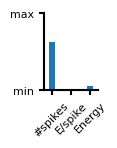

In [274]:
summstats = stats(simulation_output_1)
num_spikes_ABPD = summstats[31]
energies_ABPD_sim = summstats[28]
energyperspike_ABPD_sim = summstats[19]

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.7,1.0))
    height_num_spikes = (num_spikes_ABPD - min_num_spikes) / (max_num_spikes - min_num_spikes)
    height_energy_per_spike = (energyperspike_ABPD_sim - min_energy_per_spike) / (max_energy_per_spike - min_energy_per_spike)
    height_energy = (energies_ABPD_sim - min_energy) / (max_energy - min_energy)
    ax.bar(np.arange(0,3), [height_num_spikes, height_energy_per_spike, height_energy], width=0.3)
    ax.set_ylim([0,1])
    ax.set_xlim([-0.4, 2.4])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['#spikes', 'E/spike', "Energy"], rotation=45)
    ax.set_yticklabels(['min', 'max'])
    plt.savefig(PANEL_D2_NEW, facecolor="None", transparent=True)
    plt.show()

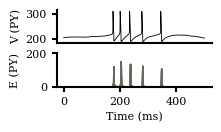

In [275]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    energy_scape(
        simulation_output_2,
        get_time(),
        (2.0, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=292000,
        neuron=0
    )
    plt.savefig(PANEL_D3_NEW, facecolor="None", transparent=True)

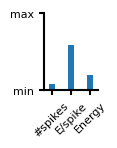

In [276]:
summstats = stats(simulation_output_2)
num_spikes_ABPD = summstats[31]
energies_ABPD_sim = summstats[28]
energyperspike_ABPD_sim = summstats[19]

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.7,1.0))
    height_num_spikes = (num_spikes_ABPD - min_num_spikes) / (max_num_spikes - min_num_spikes)
    height_energy_per_spike = (energyperspike_ABPD_sim - min_energy_per_spike) / (max_energy_per_spike - min_energy_per_spike)
    height_energy = (energies_ABPD_sim - min_energy) / (max_energy - min_energy)
    ax.bar(np.arange(0,3), [height_num_spikes, height_energy_per_spike, height_energy], width=0.3)
    ax.set_ylim([0,1])
    ax.set_xlim([-0.4, 2.4])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['#spikes', 'E/spike', "Energy"], rotation=45)
    ax.set_yticklabels(['min', 'max'])
    plt.savefig(PANEL_D4_NEW, facecolor="None", transparent=True)
    plt.show()

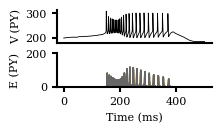

In [277]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    energy_scape(
        simulation_output_3,
        get_time(),
        (2.0, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=119000,
        neuron=0
    )
    plt.savefig(PANEL_D5_NEW, facecolor="None", transparent=True)

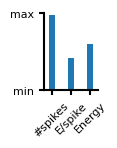

In [278]:
summstats = stats(simulation_output_3)
num_spikes_ABPD = summstats[31]
energies_ABPD_sim = summstats[28]
energyperspike_ABPD_sim = summstats[19]

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.7,1.0))
    height_num_spikes = (num_spikes_ABPD - min_num_spikes) / (max_num_spikes - min_num_spikes)
    height_energy_per_spike = (energyperspike_ABPD_sim - min_energy_per_spike) / (max_energy_per_spike - min_energy_per_spike)
    height_energy = (energies_ABPD_sim - min_energy) / (max_energy - min_energy)
    ax.bar(np.arange(0,3), [height_num_spikes, height_energy_per_spike, height_energy], width=0.3)
    ax.set_ylim([0,1])
    ax.set_xlim([-0.4, 2.4])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['#spikes', 'E/spike', "Energy"], rotation=45)
    ax.set_yticklabels(['min', 'max'])
    plt.savefig(PANEL_D6_NEW, facecolor="None", transparent=True)
    plt.show()

# Assemble figure

In [279]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [297]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "7.9cm",

    Panel(
         SVG(PANEL_A1_NEW).scale(svg_scale).move(0, 0*factor_svg),
         Text("a", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 0.0*factor_svg),
           
    Panel(
         SVG(PANEL_A2_NEW).scale(svg_scale).move(0, 0*factor_svg),
    ).move(20*factor_svg, 0.0*factor_svg),
    
    Panel(
        SVG(PANEL_B1_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(50*factor_svg, 0.0*factor_svg),
           
    Panel(
        SVG(PANEL_B2_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(70*factor_svg, 0.0*factor_svg),
    
    Panel(
          SVG(PANEL_C_NEW).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(100*factor_svg, 0*factor_svg),
    
    Panel(
          SVG(PANEL_D1_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(0*factor_svg, 30.0*factor_svg),
    
    Panel(
          SVG(PANEL_D2_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(33*factor_svg, 30.0*factor_svg),
    
    Panel(
          SVG(PANEL_D3_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(50*factor_svg, 30*factor_svg),
    
    Panel(
          SVG(PANEL_D4_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(83*factor_svg, 30*factor_svg),
           
    Panel(
          SVG(PANEL_D5_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(100*factor_svg, 30*factor_svg),
    
    Panel(
          SVG(PANEL_D6_NEW).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(133*factor_svg, 30*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig4_new.svg")
svg('../fig/fig4_new.svg')

# Panel D: num spikes and energy per spike independent

In [29]:
quantile_energy = 0.05
quantile_numSpikes = 0.05

In [30]:
data = np.load("../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz")
sample_stats = data["sample_stats"]
sample_params = data["sample_params"]
sample_seeds = data["sample_seeds"]

In [31]:
all_energies_per_spike = sample_stats[:, 18:21]
all_total_energies = sample_stats[:, 21:24]
summed_energies_per_spike = np.sum(np.asarray(all_energies_per_spike), axis=1)
summed_energies_total = np.sum(np.asarray(all_total_energies), axis=1)

In [32]:
energies_per_spike_PY = all_energies_per_spike[:, -1]
all_numbers_of_spikes_per_burst = sample_stats[:, -6:-3] / sample_stats[:, -3:]
number_of_spikes_per_burst_PY = all_numbers_of_spikes_per_burst[:, -1]

In [33]:
inds_energy_per_spike = np.argsort(energies_per_spike_PY)
inds_num_spikes = np.argsort(number_of_spikes_per_burst_PY)

In [34]:
index_energy_per_spike = inds_energy_per_spike[
    int(len(inds_energy_per_spike) * quantile_energy)
]
index_num_spikes = inds_num_spikes[int(len(inds_num_spikes) * quantile_numSpikes)]

In [35]:
energy_per_spike_threshold = energies_per_spike_PY[index_energy_per_spike]
num_spikes_threshold = number_of_spikes_per_burst_PY[index_num_spikes]

In [36]:
param_sets_with_low_energy = sample_params[
    energies_per_spike_PY < energy_per_spike_threshold
]
param_sets_with_low_num_spikes = sample_params[
    number_of_spikes_per_burst_PY < num_spikes_threshold
]

In [37]:
print(param_sets_with_low_energy.shape)
print(param_sets_with_low_num_spikes.shape)

(2752, 31)
(2686, 31)


In [38]:
number_of_spikes_per_burst_PY_low_energy = number_of_spikes_per_burst_PY[
    energies_per_spike_PY < energy_per_spike_threshold
]
params_both_low = param_sets_with_low_energy[
    number_of_spikes_per_burst_PY_low_energy < num_spikes_threshold
]

In [39]:
print(params_both_low.shape)

(91, 31)


In [42]:
all_out_targets = []
cols = [col["CONSISTENT1"], col["CONSISTENT1"]]

params1 = params_both_low[0]

target_params = params1  # * params_std_11 + params_mean_11
out_target = simulate_energyscape(deepcopy(target_params), seed=0)

all_out_targets.append(out_target)

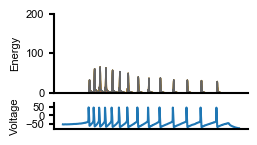

In [44]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.plot_energy_scape(
        out_target,
        2,
        get_time(),
        109000,
        129000,
        figsize=(2.5, 1.5),
        xlabel=False,
        ylabel=True,
    )
    plt.savefig(PANEL_D1, facecolor="None", transparent=True)
    plt.show()

In [45]:
quantile_energy = 1 - 0.05
quantile_numSpikes = 0.05

In [46]:
index_energy_per_spike = inds_energy_per_spike[
    int(len(inds_energy_per_spike) * quantile_energy)
]
index_num_spikes = inds_num_spikes[int(len(inds_num_spikes) * quantile_numSpikes)]

energy_per_spike_threshold = energies_per_spike_PY[index_energy_per_spike]
num_spikes_threshold = number_of_spikes_per_burst_PY[index_num_spikes]

param_sets_with_low_energy = sample_params[
    energies_per_spike_PY > energy_per_spike_threshold
]
param_sets_with_low_num_spikes = sample_params[
    number_of_spikes_per_burst_PY < num_spikes_threshold
]

print(param_sets_with_low_energy.shape)
print(param_sets_with_low_num_spikes.shape)

(2752, 31)
(2686, 31)


In [47]:
number_of_spikes_per_burst_PY_low_energy = number_of_spikes_per_burst_PY[
    energies_per_spike_PY > energy_per_spike_threshold
]
params_both_low = param_sets_with_low_energy[
    number_of_spikes_per_burst_PY_low_energy < num_spikes_threshold
]

print(params_both_low.shape)

(3, 31)


In [48]:
all_out_targets = []
cols = [col["CONSISTENT1"], col["CONSISTENT1"]]

params1 = params_both_low[0]

target_params = params1  # * params_std_11 + params_mean_11
out_target = simulate_energyscape(deepcopy(target_params), seed=0)

all_out_targets.append(out_target)

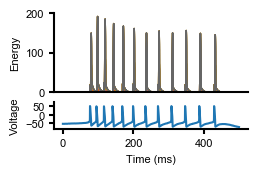

In [49]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.plot_energy_scape(
        out_target,
        2,
        get_time(),
        108000,
        128000,
        figsize=(2.5, 1.5),
        xlabel=True,
        ylabel=True,
    )
    plt.savefig(PANEL_D2, facecolor="None", transparent=True)
    plt.show()

In [50]:
quantile_energy = 0.05
quantile_numSpikes = 1 - 0.05

In [51]:
index_energy_per_spike = inds_energy_per_spike[
    int(len(inds_energy_per_spike) * quantile_energy)
]
index_num_spikes = inds_num_spikes[int(len(inds_num_spikes) * quantile_numSpikes)]

energy_per_spike_threshold = energies_per_spike_PY[index_energy_per_spike]
num_spikes_threshold = number_of_spikes_per_burst_PY[index_num_spikes]

param_sets_with_low_energy = sample_params[
    energies_per_spike_PY < energy_per_spike_threshold
]
param_sets_with_low_num_spikes = sample_params[
    number_of_spikes_per_burst_PY > num_spikes_threshold
]

print(param_sets_with_low_energy.shape)
print(param_sets_with_low_num_spikes.shape)

(2752, 31)
(2659, 31)


In [52]:
number_of_spikes_per_burst_PY_low_energy = number_of_spikes_per_burst_PY[
    energies_per_spike_PY < energy_per_spike_threshold
]
params_both_low = param_sets_with_low_energy[
    number_of_spikes_per_burst_PY_low_energy > num_spikes_threshold
]

print(params_both_low.shape)

(188, 31)


In [53]:
all_out_targets = []
cols = [col["CONSISTENT1"], col["CONSISTENT1"]]

params1 = params_both_low[0]

target_params = params1  # * params_std_11 + params_mean_11
out_target = simulate_energyscape(deepcopy(target_params), seed=0)

all_out_targets.append(out_target)

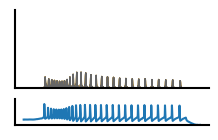

In [54]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.plot_energy_scape(
        out_target,
        2,
        get_time(),
        114000,
        134000,
        figsize=(2.5, 1.5),
        xlabel=False,
        ylabel=False,
    )
    plt.savefig(PANEL_D3, facecolor="None", transparent=True)
    plt.show()

In [55]:
quantile_energy = 1 - 0.05
quantile_numSpikes = 1 - 0.05

In [56]:
index_energy_per_spike = inds_energy_per_spike[
    int(len(inds_energy_per_spike) * quantile_energy)
]
index_num_spikes = inds_num_spikes[int(len(inds_num_spikes) * quantile_numSpikes)]

energy_per_spike_threshold = energies_per_spike_PY[index_energy_per_spike]
num_spikes_threshold = number_of_spikes_per_burst_PY[index_num_spikes]

param_sets_with_low_energy = sample_params[
    energies_per_spike_PY > energy_per_spike_threshold
]
param_sets_with_low_num_spikes = sample_params[
    number_of_spikes_per_burst_PY > num_spikes_threshold
]

print(param_sets_with_low_energy.shape)
print(param_sets_with_low_num_spikes.shape)

(2752, 31)
(2659, 31)


In [57]:
number_of_spikes_per_burst_PY_low_energy = number_of_spikes_per_burst_PY[
    energies_per_spike_PY > energy_per_spike_threshold
]
params_both_low = param_sets_with_low_energy[
    number_of_spikes_per_burst_PY_low_energy > num_spikes_threshold
]

print(params_both_low.shape)

(17, 31)


In [58]:
all_out_targets = []
cols = [col["CONSISTENT1"], col["CONSISTENT1"]]

params1 = params_both_low[0]

target_params = params1  # * params_std_11 + params_mean_11
out_target = simulate_energyscape(deepcopy(target_params), seed=0)

all_out_targets.append(out_target)

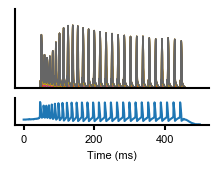

In [59]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.plot_energy_scape(
        out_target,
        2,
        get_time(),
        100000,
        120000,
        figsize=(2.5, 1.5),
        xlabel=True,
        ylabel=False,
    )
    plt.savefig(PANEL_D4, facecolor="None", transparent=True)
    plt.show()

# Assembe figure

In [127]:
import time

import IPython.display as IPd


def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [128]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "7.9cm",

    Panel(
         SVG(PANEL_A).scale(svg_scale).move(0, 0*factor_svg),
         Text("a", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 0.0*factor_svg),
    
    Panel(
        SVG(PANEL_B1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", 0.0*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 22.0*factor_svg),
           
    Panel(
        SVG(PANEL_B2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(28*factor_svg, 22.0*factor_svg),
    
    Panel(
          SVG(PANEL_C1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 39*factor_svg),
    
    Panel(
          SVG(PANEL_C2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(28*factor_svg, 39*factor_svg),
    
    Panel(
          SVG(PANEL_D1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
          Text("d", 0*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(58*factor_svg, 1.0*factor_svg),
    
    Panel(
          SVG(PANEL_D2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(58*factor_svg, 27.0*factor_svg),
    
    Panel(
          SVG(PANEL_D3).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(98*factor_svg, 1.7*factor_svg),
    
    Panel(
          SVG(PANEL_D4).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(98*factor_svg, 27.7*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig4.svg")
svg('../fig/fig4.svg')

### Assemble supplementary

In [129]:
f = Figure("20.3cm", "3.9cm",

    Panel(
         SVG(PANEL_supp1).scale(svg_scale).move(0, 0*factor_svg),
         Text("a", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 0.0*factor_svg),
    
    Panel(
        SVG(PANEL_supp2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(50*factor_svg, 0.0*factor_svg),
    
)

!mkdir -p fig
f.save("../fig/fig4_supp_convergence.svg")
svg('../fig/fig4_supp_convergence.svg')